In [197]:
import os, glob
import sys
from sys import stderr
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import datetime
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.enable_eager_execution()
from tensorflow.keras import backend as K, preprocessing, \
                             models, layers, optimizers, \
                             utils, callbacks, initializers, \
                             activations, regularizers, applications, \
                             constraints, Model
import numpy as np
import numpy.random as rand
import scipy.fftpack as fft
import six
import cv2 as cv
import pandas as pd
import peakutils
import urllib as url
import requests
import bs4
import skimage.util as util
from numpy import linalg as la, random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [25]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
cwd = 'D:/Kenneth/Documents/VIP/Datasets/dr2imagenet/'
traindir = cwd + 'train/'
testdir = cwd + 'test/'

# Download data

In [48]:
def pull_data(adr, savedir, prefix, timeout=3, max_imgs=0):
    page = requests.get(adr)
    soup = bs4.BeautifulSoup(page.content, 'html.parser')
    str_soup = str(soup)
    split_urls = str_soup.split('\r\n')
    print(len(split_urls))

    count = 1
    for adr in tqdm(split_urls):
        try:
            resp = url.request.urlopen(adr, timeout=timeout)
            image = np.asarray(bytearray(resp.read()), dtype='uint8')
            image = cv.imdecode(image, cv.IMREAD_COLOR)
            filename = prefix + '.' + str(count) + '.' + adr.split('.')[-1]
            if len(image.shape) >= 2:
                cv.imwrite(savedir + filename, image)
                if (max_imgs != 0) and (count == max_imgs):
                    return count
                else:
                    count += 1
            else:
                continue
        except:
            continue

In [49]:
pull_data('http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n00017222', 
          traindir, 
          'flower')

1272


D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [53]:
pull_data('http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n09618957', 
          traindir, 
          'face')

1571


D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [54]:
pull_data('http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02913152', 
          traindir, 
          'architecture')

1422


D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


# Training data pre-processing

In [243]:
filenames = os.listdir(traindir)
patch_size = 33
stride = 14
scales = [0.75, 1, 1.5]
batch_size = 128
epoch = int(1e6)

In [256]:
def read_im(filename):
    im_str = tf.read_file(filename)
    im_dec = tf.image.decode_jpeg(im_str, channels=1)
    im = tf.image.convert_image_dtype(im_dec, tf.float32)
    return im

def _get_patches(image, window_size, stride):
    image = tf.expand_dims(image, 0)
    patches = tf.extract_image_patches(image,
                                       ksizes=[1, window_size, window_size, 1],
                                       strides=[1, stride, stride, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')
    return patches

get_patches = lambda image: _get_patches(image, patch_size, stride)

In [258]:
train_ds = tf.data.Dataset.from_tensor_slices(filenames)
train_ds = train_ds.map(read_im, num_parallel_calls=4)
train_ds = train_ds.map(get_patches, num_parallel_calls=4)
train_ds = train_ds.apply(tf.contrib.data.unbatch())
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.contrib.data.AUTOTUNE)

# Initialize network

In [6]:
std_init = 0.001
max_iter = int(1e6)
lr_init = 0.001
step_size = int(2e5)
gamma = 0.5

In [4]:
def ResidualLearningBlock(input_img, blocknum):
    FT = klay.Conv2D(filters=64,
                     kernel_size=(11, 11),
                     activation='relu',
                     padding='same',
                     kernel_initializer=kinit.RandomNormal(stddev=std_init,
                                                           seed=seed),
                     name='res{0}_conv1'.format(blocknum))(input_img)
    FT = klay.BatchNormalization(center=True,
                                 scale=True,
                                 gamma_initializer=kinit.Constant(gamma),
                                 name='res{0}_norm1'.format(blocknum))(FT)
    FT = klay.Conv2D(filters=32,
                     kernel_size=(1, 1),
                     activation='relu',
                     padding='same',
                     kernel_initializer=kinit.RandomNormal(stddev=std_init,
                                                           seed=seed),
                     name='res{0}_conv2'.format(blocknum))(FT)
    FT = klay.BatchNormalization(center=True,
                                 scale=True,
                                 gamma_initializer=kinit.Constant(gamma),
                                 name='res{0}_norm2'.format(blocknum))(FT)
    FT = klay.Conv2D(filters=1,
                     kernel_size=(7, 7),
                     padding='same',
                     kernel_initializer=kinit.RandomNormal(stddev=std_init,
                                                           seed=seed),
                     name='res{0}_conv3'.format(blocknum))(FT)
    return FT

In [32]:
input_img = klay.Input(shape=(img_dim, img_dim, img_ch),
                       name='linmap_input')

# Linear mapping block
x = klay.Flatten(name='linmap_flatten')(input_img)
x = klay.Dense(img_dim**2,
               kernel_initializer=kinit.RandomNormal(stddev=0.01),
               name='linmap_fc')(x)
x = klay.Reshape(target_shape=(img_dim, img_dim, img_ch),
                 name='linmap_reshape')(x)

# Residual learning block 1
FT1 = ResidualLearningBlock(x, 1)

# Linear mapping + residual block 1
add = klay.Add(name='add1')([x, FT1])

# Residual learning block 2
FT2 = ResidualLearningBlock(add, 2)

# Add 1 + residual block 2
add = klay.Add(name='add2')([add, FT2])

# Residual learning block 3
FT3 = ResidualLearningBlock(add, 3)

# Add 2 + residual block 3
add = klay.Add(name='add3')([add, FT3])

# Residual learning block 4
FT4 = ResidualLearningBlock(add, 4)

# Add 3 + residual block 4
add = klay.Add(name='add4')([add, FT4])

dr2net = kmod.Model(input_img, add)
dr2net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
linmap_input (InputLayer)       (None, 33, 33, 1)    0                                            
__________________________________________________________________________________________________
linmap_flatten (Flatten)        (None, 1089)         0           linmap_input[0][0]               
__________________________________________________________________________________________________
linmap_fc (Dense)               (None, 1089)         1187010     linmap_flatten[0][0]             
__________________________________________________________________________________________________
linmap_reshape (Reshape)        (None, 33, 33, 1)    0           linmap_fc[0][0]                  
__________________________________________________________________________________________________
res1_conv1

In [7]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def l2loss(y_true, y_pred):
    return tf.cast(1/tf.size(y_true), tf.float32) * tf.reduce_sum(tf.norm(y_true - y_pred, ord=2)**2)

def step_decay_schedule(initial_lr, decay_factor, step_size):
    def schedule(epoch):
        return initial_lr * (decay_factor**(epoch//step_size))
    return kcall.LearningRateScheduler(schedule)

In [8]:
checkpoint = kcall.ModelCheckpoint('dr2net_best_weights.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')
history = kcall.History()
sgd = kopt.SGD(lr=lr_init,
               momentum=0.9)
lr_sched = step_decay_schedule(initial_lr=lr_init,
                               decay_factor=100,
                               step_size=100000)
epochs = 40

In [162]:
dr2net.compile(optimizer=sgd,
               loss=l2loss,
               metrics=[psnr, ssim])

In [163]:
dr2net.load_weights('dr2net_best_weights.h5')

In [ ]:
dr2net.fit_generator(train_gen,
                     epochs=epochs,
                     validation_data=val_gen,
                     validation_steps=total_val//batch_size,
                     steps_per_epoch=total_train//batch_size,
                     verbose=0,
                     callbacks=[ktqdm(), lr_sched, history, checkpoint])
dr2net.save('dr2net.model')

In [9]:
dr2net = kmod.load_model('dr2net.model', custom_objects={'l2loss': l2loss,
                                                         'psnr': psnr,
                                                         'ssim': ssim})
dr2net.load_weights('dr2net_best_weights.h5')

W0814 12:10:04.208117 14692 module_wrapper.py:136] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 12:10:05.680608 14692 module_wrapper.py:136] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0814 12:10:06.941605 14692 module_wrapper.py:136] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 12:10:07.175642 14692 deprecation.py:323] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1206: where (from tensorflow.python.ops.array_ops) is deprecated and will b

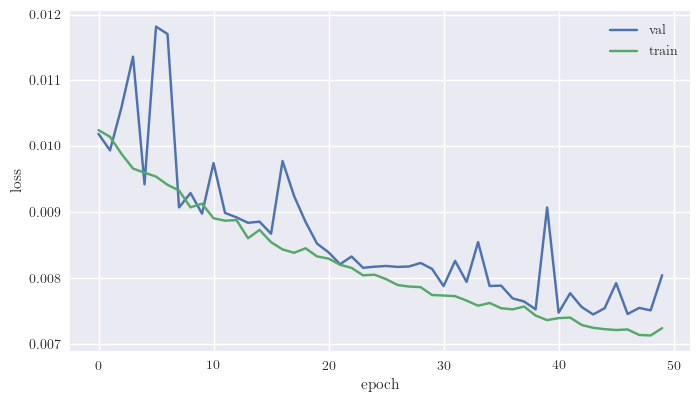

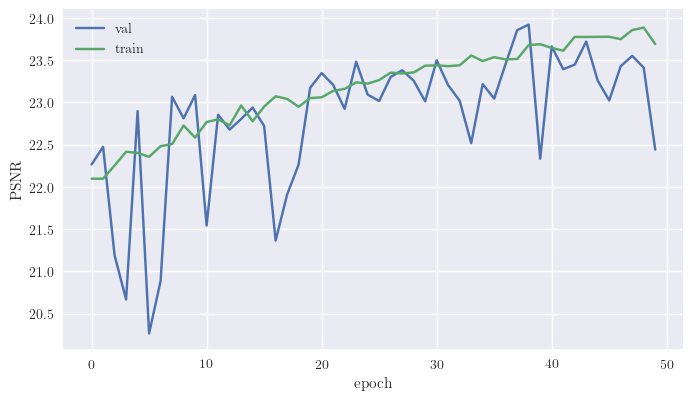

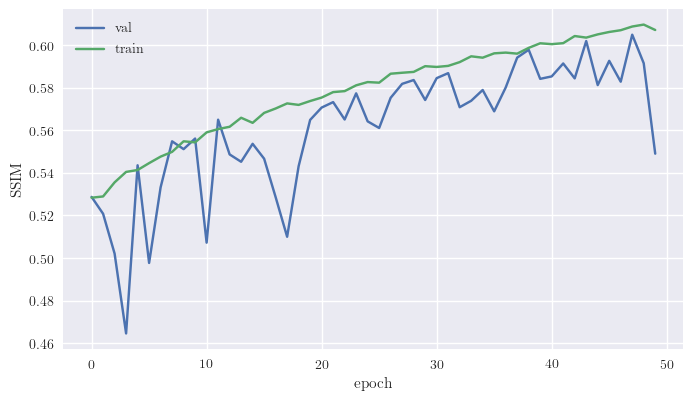

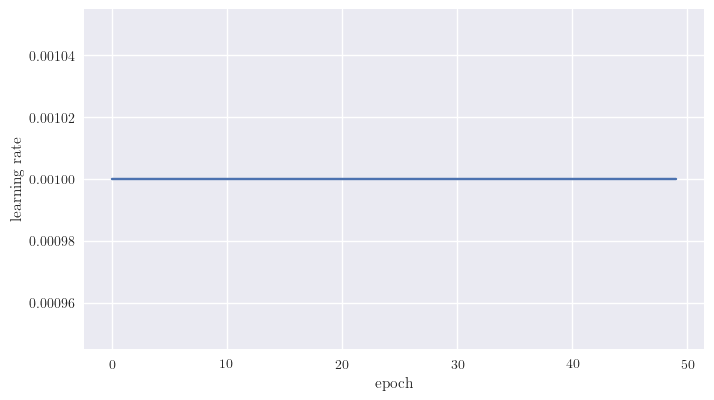

In [34]:
mp.figure()
mp.plot(history.epoch, history.history['val_loss'],
        history.epoch, history.history['loss'])
mp.xlabel('epoch')
mp.ylabel('loss')
mp.legend(['val', 'train'])
# mp.savefig('190813-dr2net-loss-50.png', 
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()

mp.figure()
mp.plot(history.epoch, history.history['val_psnr'],
        history.epoch, history.history['psnr'])
mp.xlabel('epoch')
mp.ylabel('PSNR')
mp.legend(['val', 'train'])
# mp.savefig('190813-dr2net-psnr-50.png', 
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()

mp.figure()
mp.plot(history.epoch, history.history['val_ssim'],
        history.epoch, history.history['ssim'])
mp.xlabel('epoch')
mp.ylabel('SSIM')
mp.legend(['val', 'train'])
# mp.savefig('190813-dr2net-ssim-50.png', 
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()

mp.figure()
mp.plot(history.epoch, history.history['lr'])
mp.xlabel('epoch')
mp.ylabel('learning rate')
# mp.savefig('190810-autoenc-lr-50.png', 
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()

# Extract test patches

In [10]:
strides = 33
window = 33
ksizes = [1, window, window, 1]
ssizes = [1, strides, strides, 1]
rates = [1, 1, 1, 1]

In [11]:
filenames = os.listdir(origtestdir)
for f in tqdm(filenames):
    orig = cv.imread(origtestdir + f, 0)    # convert to grayscale
    h_i, w_i = orig.shape
    image = tf.convert_to_tensor(orig)
    image = tf.expand_dims(image, 0)
    image = tf.expand_dims(image, -1)
    patches = tf.extract_image_patches(image, ksizes, ssizes, rates, padding='VALID')
    patches = tf.reshape(patches, [-1, window, window])
    patches = tf.Session().run(patches)
    for p in tnrange(patches.shape[0], leave=False):
        newname = f.split('.')[0] + '.' + str(p) + '.' + f.split('.')[-1]
        cv.imwrite(testdir + newname, patches[p])

W0814 12:10:09.026865 14692 deprecation.py:506] From <ipython-input-11-d74e4505696d>:8: calling extract_image_patches (from tensorflow.python.ops.array_ops) with ksizes is deprecated and will be removed in a future version.
Instructions for updating:
ksizes is deprecated, use sizes instead


# Test patch preprocessing

In [12]:
filenames = os.listdir(testdir)
categories = np.zeros(len(filenames), int)
test_df = pd.DataFrame({'filename': filenames,
                         'category': categories})

In [13]:
test_df.head()

filename  category
0   baboon.0.jpg         0
1   baboon.1.jpg         0
2  baboon.10.jpg         0
3  baboon.11.jpg         0
4  baboon.12.jpg         0

In [14]:
test_df.tail()

filename  category
1815  peppers256.5.png         0
1816  peppers256.6.png         0
1817  peppers256.7.png         0
1818  peppers256.8.png         0
1819  peppers256.9.png         0

In [15]:
def compress_input(x, ratio=0.25):
    mask = np.zeros_like(x, 'uint8')
    mask.T.flat[:] = rand.choice([0,1], size=mask.size, p=[1-ratio, ratio])
    X = x*mask
    return X

In [16]:
test_datagen = kpre.image.ImageDataGenerator(rescale=1/255,
                                             preprocessing_function=compress_input)
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            testdir,
                                            x_col='filename',
                                            y_col=None,
                                            target_size=img_size,
                                            batch_size=batch_size,
                                            color_mode='grayscale',
                                            class_mode='input',
                                            shuffle=False)

Found 1820 images.


In [17]:
x_test = test_gen.next()

In [19]:
rec = dr2net.predict(x_test[0])

W0814 12:10:30.687682 14692 module_wrapper.py:136] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



InternalError: 2 root error(s) found.
  (0) Internal: Blas GEMM launch failed : a.shape=(32, 1089), b.shape=(1089, 1089), m=32, n=1089, k=1089
	 [[{{node linmap_fc/MatMul}}]]
	 [[add4/add/_779]]
  (1) Internal: Blas GEMM launch failed : a.shape=(32, 1089), b.shape=(1089, 1089), m=32, n=1089, k=1089
	 [[{{node linmap_fc/MatMul}}]]
0 successful operations.
0 derived errors ignored.

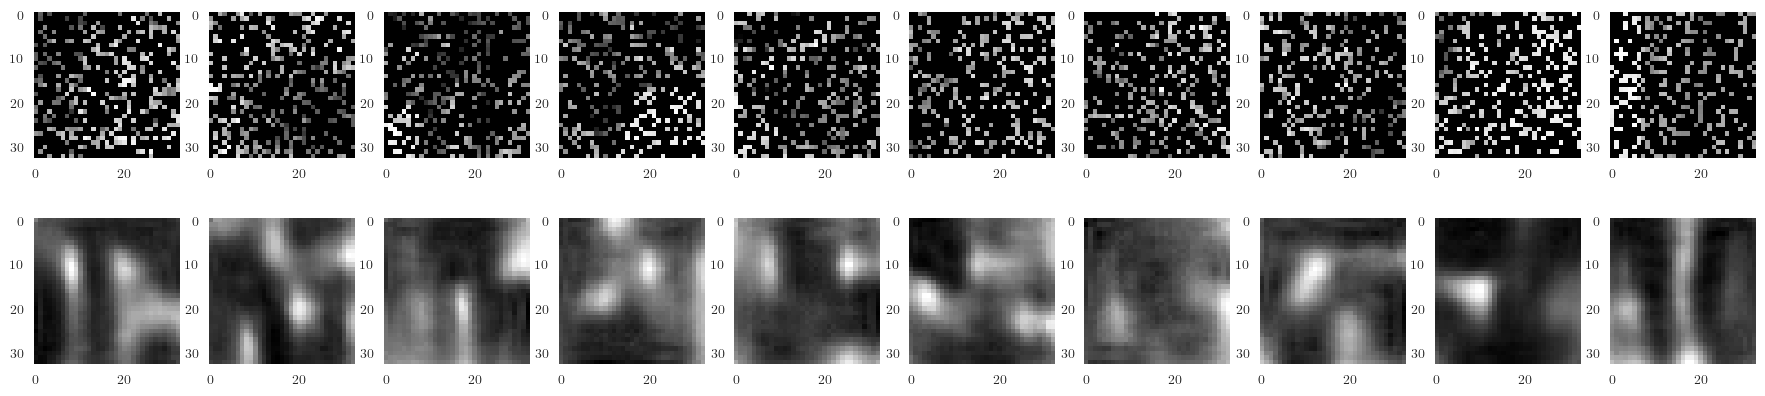

In [136]:
fig = mp.figure(figsize=(5*16/9*2.5, 5))
for i in range(10):
    ax = fig.add_subplot(2, 10, i+1)
    ax.imshow(x_test[i,:,:,0], 'gray')
    ax.grid(False)
    
    ax = fig.add_subplot(2, 10, 10+i+1)
    ax.imshow(rec[i,:,:,0], 'gray')
    ax.grid(False)
    
mp.show()